We will implement a Gibbs sampling algortihm to sample the factors from the conditional posterior distrubtions in the MVGMF algorithm to factorise our matrix. We will call this algortihm Bayesian Gaussian Matrix Factorisation (BGMF) for now.

In [294]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
import pandas as pd
plt.style.use('seaborn-white')

In [295]:
def calculate_nmse(Y, Y_pred):
    numerator = np.linalg.norm(Y - Y_pred, 'fro') ** 2
    denominator = np.linalg.norm(Y, 'fro') ** 2
    nmse = numerator / denominator
    return nmse

In [296]:
def matrix_normal_sample(M, U, V):
    #return np.random.multivariate_normal(M.ravel(), np.kron(V, U)).reshape(M.shape)
    n, p = M.shape

    # Generate samples from standard normal distribution
    X = np.random.normal(0, 1, size=(n, p))

    # Compute Cholesky decomposition of covariance matrices
    chol_U = np.linalg.cholesky(U)
    chol_V = np.linalg.cholesky(V)

    # Sample from matrix normal distribution
    Y = M + chol_U @ X @ chol_V.T

    return Y

In [317]:
def BGMF(Y, k, r, T, sigma_2, burnin = 100, return_running_average = False, return_samples=False, mask=None):
    """
    Perform Bayesian Gaussian Matrix Factorization (BGMF) using Gibbs sampling.

    Parameters:
    - Y (numpy.ndarray): The input matrix of shape (m, n) to be factorized.
    - k (float): A constant for the variate matrix initialization.
    - r (int): The dimensionality of the factorization.
    - T (int): The number of Gibbs sampling iterations.
    - burnin(int): Specifies burnin iterations.
    - return_running_average (boolean): Returns additionally running array average of C and X.
    - return_samples (boolean): Returns array of samples of C, X, V and W at each iteration.
    - mask (numpy.ndarray): shape (m, n) which is the mask matrix to be used for missing data cases

    Returns:
    - C (numpy.ndarray): The factor matrix C of shape (m, r).
    - X (numpy.ndarray): The factor matrix X of shape (r, n).
    """
    m, n = Y.shape
    #Initialise the matrices
    V_0 = k * np.eye(r)
    W_0 = k * np.eye(r)
    C_0 = np.random.normal(0, 1, size=(m, r))
    X_0 = np.random.normal(0, 1, size=(r, n))
    C_prev = C_0.copy()
    X_prev = X_0.copy()

    #Stores running average of C and X after burnin
    C_samples = []
    X_samples = []
    V_samples = []
    W_samples = []
    C_running_average = []
    X_running_average = []
    C_average = np.zeros((m, r))
    X_average = np.zeros((r, n))
    C_mean_array = []
    X_mean_array = []

    for t in range(T):
        print(t)
        V = V_0 - V_0 @ X_prev @ np.linalg.inv(sigma_2*np.eye(n) + X_prev.T @ V_0 @ X_prev) @ X_prev.T @ V_0
        #V = V - V @ X_prev @ np.linalg.inv(sigma_2*np.eye(n) + X_prev.T @ V @ X_prev) @ X_prev.T @ V
        
        if mask is not None:
            C_mean = C_prev + (mask * (Y - C_prev @ X_prev)) @ \
                    np.linalg.inv(sigma_2*np.eye(n) + X_prev.T @ V_0 @ X_prev).T @ X_prev.T @ V_0.T
            
        else:
            C_mean = C_prev + (Y - C_prev @ X_prev) @ \
                        np.linalg.inv(sigma_2*np.eye(n) + X_prev.T @ V_0 @ X_prev).T @ X_prev.T @ V_0.T
        
        C = matrix_normal_sample(C_mean, np.eye(m), V)
        
        W = W_0 - W_0 @ C.T @ np.linalg.inv(sigma_2*np.eye(m) + C @ W_0 @ C.T) @ C @ W_0
        #W = W - W @ C.T @ np.linalg.inv(sigma_2*np.eye(m) + C @ W @ C.T) @ C @ W
        
        if mask is not None:
            X_mean = X_prev + W_0 @ C.T @ np.linalg.inv(sigma_2*np.eye(m) + C @ W_0 @ C.T) @ (mask * (Y - C @ X_prev))
        
        else:
            X_mean = X_prev + W_0 @ C.T @ np.linalg.inv(sigma_2*np.eye(m) + C @ W_0 @ C.T) @ (Y - C @ X_prev)
        
        X = matrix_normal_sample(X_mean, W, np.eye(n))
        
        C_prev = C
        X_prev = X
        
        if t >= burnin:
            #Calculates the running average of C and X (to plot)
            if t == burnin:
                C_average = C
                X_average = X
                C_running_average.append(C_average)
                X_running_average.append(X_average)
                
            else:
                N = t - burnin + 1
                C_average = (C / N) + (C_average * (N - 1) / N)
                X_average = (X / N) + (X_average * (N - 1) / N)
                C_running_average.append(C_average)
                X_running_average.append(X_average)
                
            C_mean_array.append(C_mean)
            X_mean_array.append(X_mean)
                
            #Stores the samples at each stage after burnin
            C_samples.append(C)
            X_samples.append(X)
            V_samples.append(V)
            W_samples.append(W)
                    

    if return_running_average:
        return C_average, X_average, C_running_average, X_running_average
    
    elif return_samples:
        return C_average, X_average, C_samples, X_samples, V_samples, W_samples, C_0, X_0, V_0, W_0, C_mean_array, X_mean_array
            
    return C_average, X_average

In [298]:
def calculate_running_average(Y):
    result = []
    result.append(Y[0])
    Y_average = Y[0]
    for i in range(1, len(Y)):
        Y_average = (Y[i] / (i+1)) + (Y_average * (i) / (i+1))
        result.append(Y_average)
    return np.array(result)

### BGMF application on low dimensional generated data

In [247]:
np.random.seed(0)
m = 5
r = 3
n = 4
burnin = 500
T = 4000
sigma_2 = 1
k = 0.001

C = np.random.normal(10, 1, size=(m, r))
X = np.random.normal(5, 1, size=(r, n))

Y = C @ X + np.random.normal(0, np.sqrt(sigma_2), size=(m, n))
#C_pred, X_pred, C_average, X_average = BGMF(Y, 1, r, T, burnin = burnin, return_running_average = True)
C_pred, X_pred, C_samples, X_samples, V_samples, W_samples, C_0, X_0, V_0, W_0, C_mean_array, X_mean_array \
                    = BGMF(Y, k, r, T, sigma_2, burnin = burnin, return_samples = True)
    
C_average = calculate_running_average(C_samples)
X_average = calculate_running_average(X_samples)

Y_pred = C_pred @ X_pred
#RUNNING PREDICITION CALCULATION
Y_pred_running = np.array([C @ X for C, X in zip(C_average, X_average)])
nmse_running = [calculate_nmse(Y, Y_pred) for Y_pred in Y_pred_running]


NMSE at 0th iteration: 0.9959745707601977
NMSE at final iteration: 9.534379732574978e-06


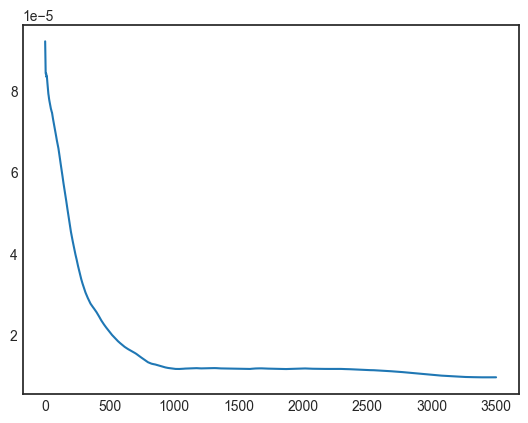

In [248]:
plt.plot(range(T-burnin), nmse_running)
print(f"NMSE at 0th iteration: {calculate_nmse(Y, C_0 @ X_0)}")
print(f"NMSE at final iteration: {calculate_nmse(Y, Y_pred)}")

Text(0.5, 1.0, 'How C_2,2 varies')

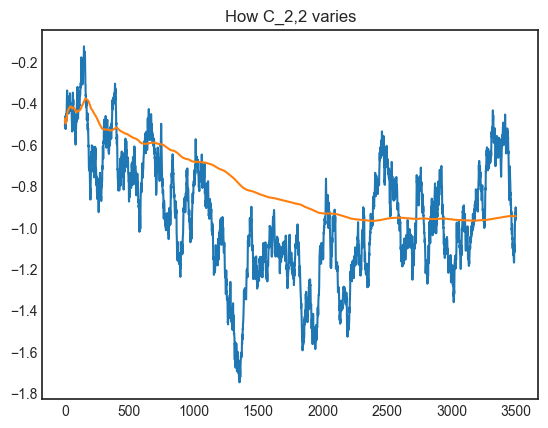

In [249]:
num_samples = len(C_mean_array)
C_mean_array = np.array(C_mean_array)
C_samples = np.array(C_samples)
plt.plot(range(num_samples), C_mean_array[:, 2, 2])
plt.plot(range(num_samples), C_average[:, 2, 2])
#plt.axhline(y=C[1,1], color='r', linestyle='-')
plt.title('How C_2,2 varies')


Text(0.5, 1.0, 'How X_2,2 varies')

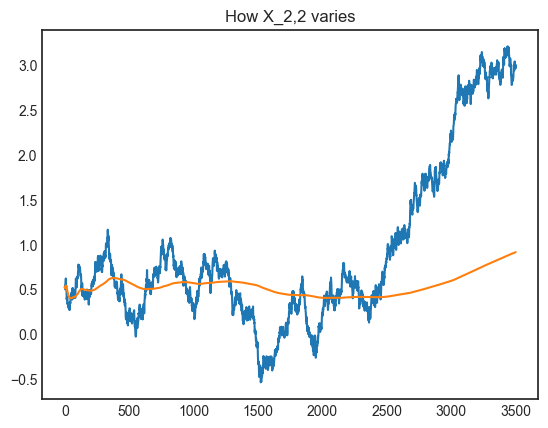

In [250]:
num_samples = len(X_mean_array)
X_mean_array = np.array(X_mean_array)
#print(X[2, 2])
plt.plot(range(num_samples), X_mean_array[:, 2, 2])
plt.plot(range(num_samples), X_average[:, 2, 2])
#plt.axhline(y=X[1,1], color='r', linestyle='-')
plt.title('How X_2,2 varies')

Text(0.5, 1.0, 'How Average of reconsutrcted Y_2,2 varies')

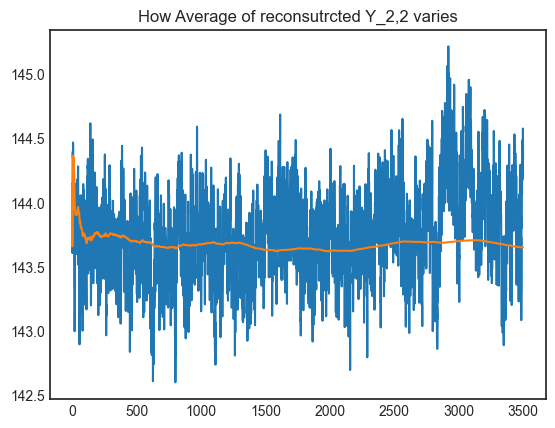

In [251]:
Y_array = np.array([C @ X for C, X in zip(C_mean_array, X_mean_array)])

plt.plot(range(num_samples), Y_array[:, 2, 2], label='Y constructed from the means of C and X at each iteration')
plt.plot(range(num_samples), Y_pred_running[:, 2, 2], label='Y constructed from the running average of samples output of C and X')   
plt.title('How Average of reconsutrcted Y_2,2 varies')

Code to trace plot Y for all m x n elements

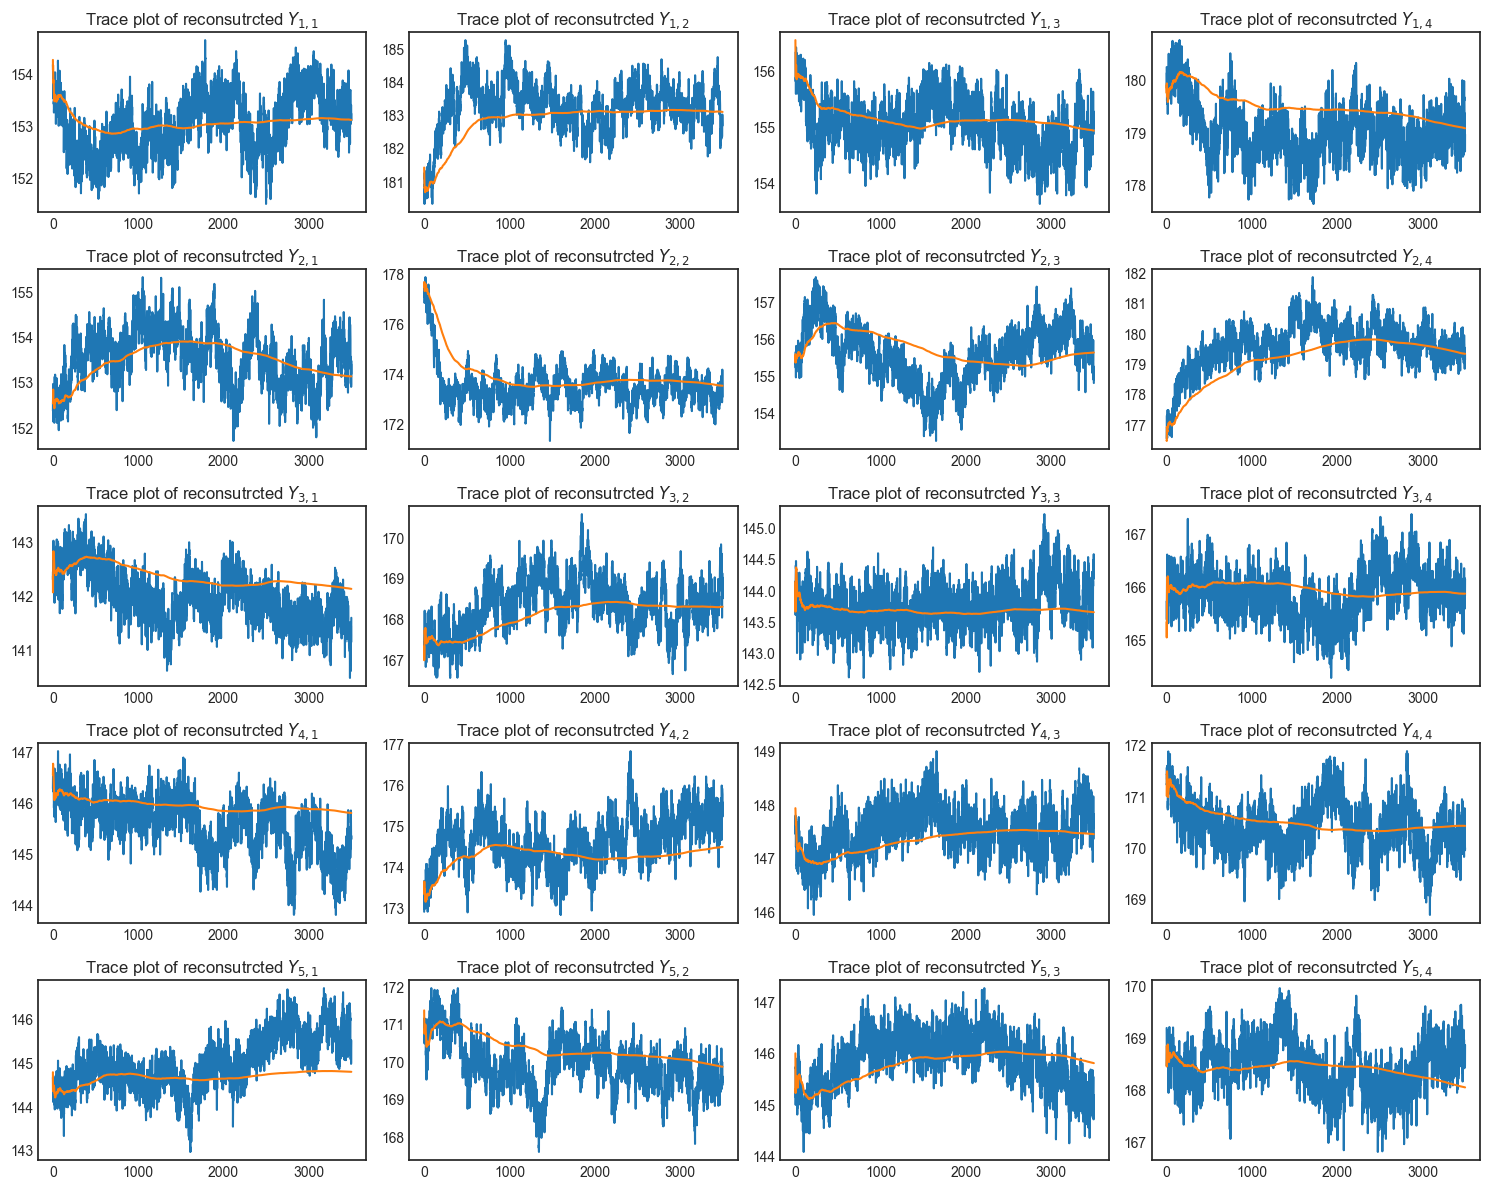

In [252]:
fig, axs = plt.subplots(m, n, figsize=(m*3, n*3)) 

for i in range(m):
    for j in range(n):
        axs[i, j].plot(range(num_samples), Y_array[:, i, j])
        axs[i, j].plot(range(num_samples), Y_pred_running[:, i, j])
        axs[i, j].set_title(f"Trace plot of reconsutrcted $Y_{{{i+1}, {j+1}}}$")


plt.tight_layout()
plt.show()

### Higher Dimension BGMF application on sythentic data

In [253]:
np.random.seed(0)
m = 100
r = 5
n = 25
burnin = 50
T = 400
sigma_2 = 1
k = 0.01

C = np.random.normal(5, 1, size=(m, r))
X = np.random.normal(2, 1, size=(r, n))

Y = C @ X + np.random.normal(0, np.sqrt(sigma_2), size=(m, n))
#C_pred, X_pred, C_average, X_average = BGMF(Y, 1, r, T, burnin = burnin, return_running_average = True)
C_pred, X_pred, C_samples, X_samples, V_samples, W_samples, C_0, X_0, V_0, W_0, C_mean_array, X_mean_array \
                    = BGMF(Y, k, r, T, sigma_2, burnin = burnin, return_samples = True)
    
C_average = calculate_running_average(C_samples)
X_average = calculate_running_average(X_samples)

Y_pred = C_pred @ X_pred

Y_pred_running = np.array([C @ X for C, X in zip(C_average, X_average)])
nmse_running = [calculate_nmse(Y, Y_pred) for Y_pred in Y_pred_running]

NMSE at 0th iteration: 1.0037375347091602
NMSE at final iteration: 0.00035145019003778494


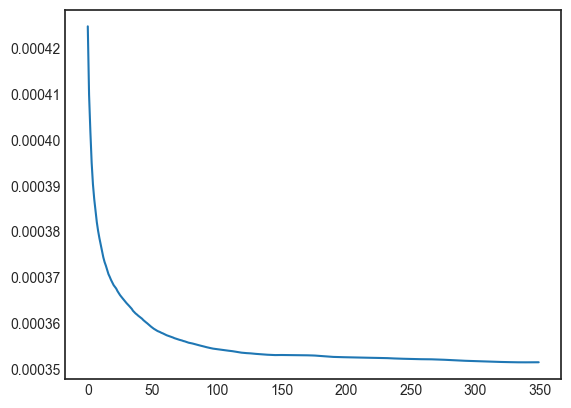

In [254]:
plt.plot(range(T-burnin), nmse_running)
print(f"NMSE at 0th iteration: {calculate_nmse(Y, C_0 @ X_0)}")
print(f"NMSE at final iteration: {calculate_nmse(Y, Y_pred)}")

### Testing Missing Data Application of BGMF



In [255]:
np.random.seed(0)
m = 30
r = 10
n = 15
burnin = 1000
T = 1500
sigma_2 = 1
k = 0.0001

#Generate the data
C = np.random.normal(10, 1, size=(m, r))
X = np.random.normal(5, 1, size=(r, n))
Y = C @ X + np.random.normal(0, np.sqrt(sigma_2), size=(m, n))

#Remove 20% of the data
num_to_remove = int(Y.size * 0.3)

indices_to_remove = np.random.choice(Y.size, num_to_remove, replace=False)
row_indices_to_remove = indices_to_remove // n
col_indices_to_remove = indices_to_remove % n

mask = np.ones_like(Y, dtype=int)
mask[row_indices_to_remove, col_indices_to_remove] = 0

Y_removed = Y * mask
not_mask = np.logical_not(mask)

NMSE at 0th iteration: 1.0000116537052257
NMSE at final iteration: 5.4376144934766495e-05


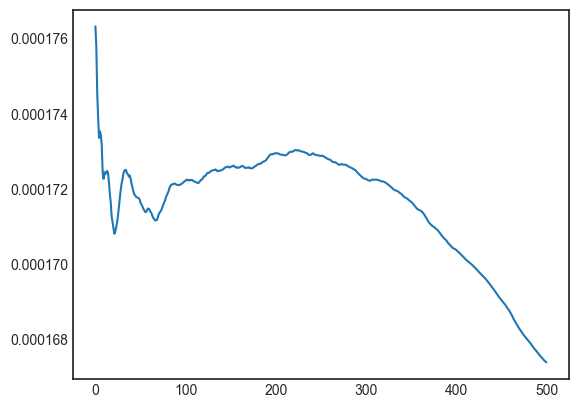

In [256]:
#Run BGMF with missing data Y_removed and mask
C_pred, X_pred, C_samples, X_samples, V_samples, W_samples, C_0, X_0, V_0, W_0, C_mean_array, X_mean_array \
                    = BGMF(Y_removed, k, r, T, sigma_2, burnin = burnin, return_samples = True, mask = mask)
    
C_average = calculate_running_average(C_samples)
X_average = calculate_running_average(X_samples)

Y_pred = C_pred @ X_pred
#RUNNING PREDICITION CALCULATION
Y_pred_running = np.array([C @ X for C, X in zip(C_average, X_average)])
nmse_running = [calculate_nmse(not_mask * Y, not_mask * Y_pred) for Y_pred in Y_pred_running]

plt.plot(range(T-burnin), nmse_running)
print(f"NMSE at 0th iteration: {calculate_nmse(Y, C_0 @ X_0)}")
print(f"NMSE at final iteration: {calculate_nmse(Y, Y_pred)}")

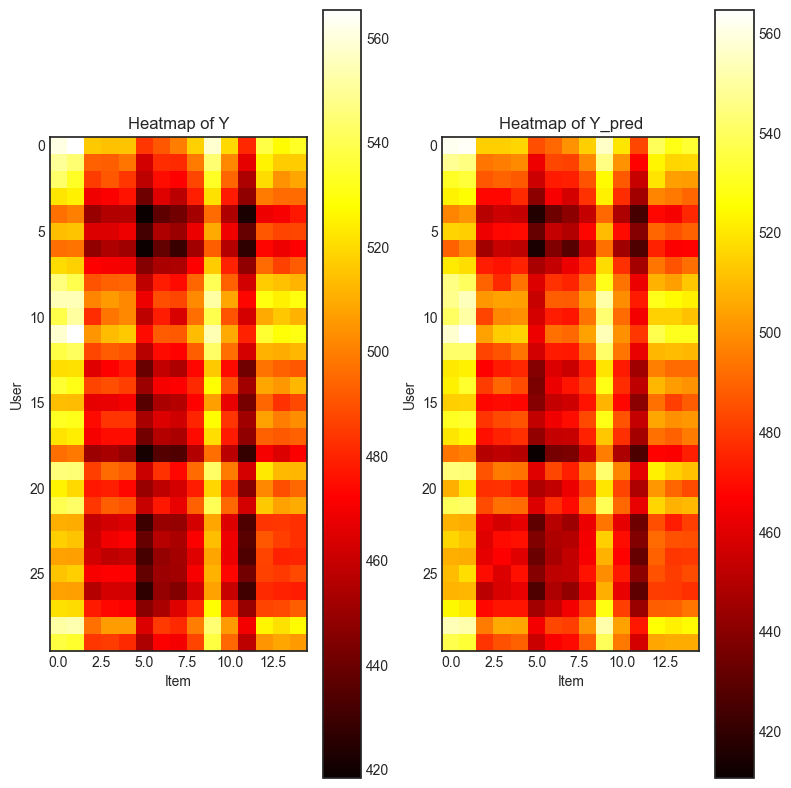

In [257]:
# Plotting the heatmaps side by side
plt.figure(figsize=(8, 8))

# Heatmap for Y
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.imshow(Y, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Heatmap of Y')
plt.xlabel('Item')
plt.ylabel('User')

# Heatmap for Y_pred
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.imshow(Y_pred, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Heatmap of Y_pred')
plt.xlabel('Item')
plt.ylabel('User')

plt.tight_layout()
plt.show()

### Application to Beijing Temperature dataset

In [310]:
#load the Beijing temperature data
Y_temperature = np.loadtxt("beijing_temperature_dataset.csv", delimiter=",")
print(Y_temperature.shape)

#too large take a subset of 5000
Y_temperature = Y_temperature[:, :500]

### DOESN'T SEEM TO HELP ###
#Normalise row wise and scale by standard deviation 
row_means = np.mean(Y_temperature, axis=1, keepdims=True)
#row_std = np.std(Y_temperature, axis=1, keepdims=True)

#Centre the data
Y_temperature = (Y_temperature - row_means) #/ row_std

(3, 43824)


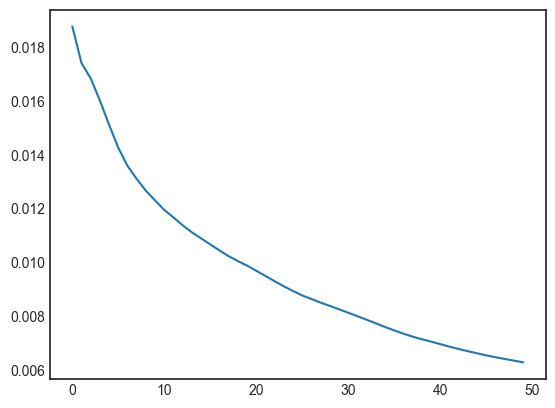

In [315]:
#Run for r = 2
np.random.seed(0)
burnin = 200
T = 250
sigma_2 = 1
k = 0.1
r = 3

C_pred, X_pred, C_running_average, X_running_average = BGMF(Y_temperature, k, r, T, sigma_2, burnin, return_running_average=True)

Y_pred = C_pred @ X_pred
Y_pred_running = np.array([C @ X for C, X in zip(C_running_average, X_running_average)])
nmse_running = [calculate_nmse(Y_temperature, Y_pred) for Y_pred in Y_pred_running]

plt.plot(range(T-burnin), nmse_running)

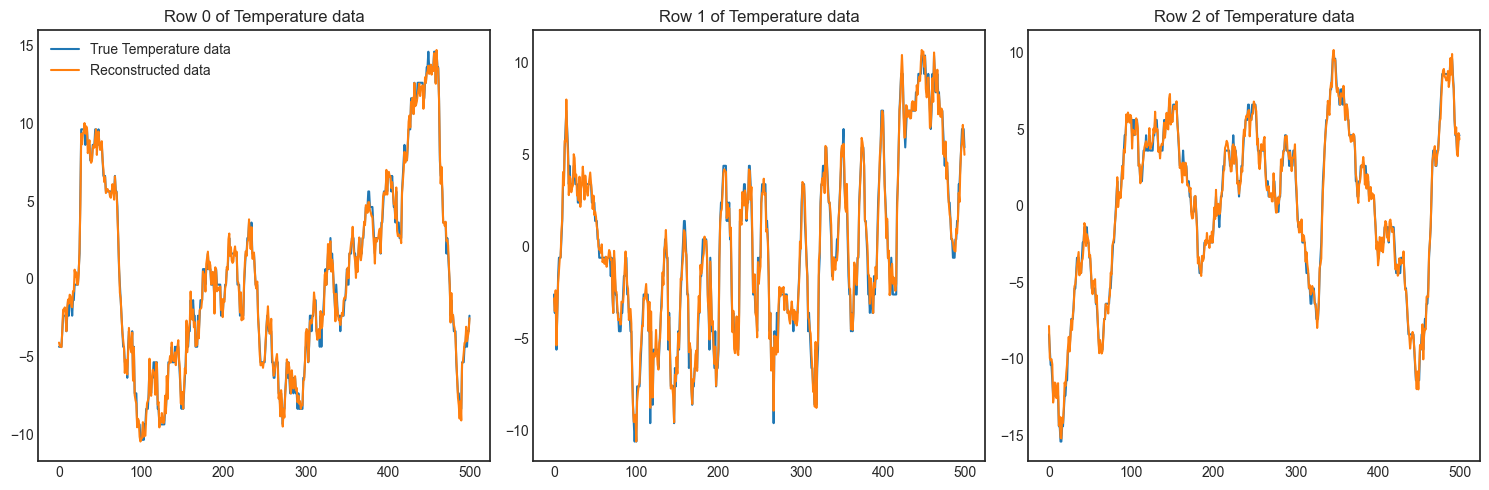

In [316]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

for i in range(3):
    axs[i].plot(Y_temperature[i, :], label='True Temperature data')
    axs[i].plot(Y_pred[i, :], label='Reconstructed data')
    axs[i].set_title(f"Row {i} of Temperature data")

    if i == 0:
        axs[0].legend()

plt.tight_layout()
plt.show()


### Beijing missing data application

In the following, I will remove chunks of the Beijing dataset in each dimension, and apply the BGMF algorithm with mask for data imputation.

In [318]:
#load the Beijing temperature data
Y_temperature = np.loadtxt("beijing_temperature_dataset.csv", delimiter=",")
print(Y_temperature.shape)

#too large take a subset of 5000
Y_temperature = Y_temperature[:, :500]


#Normalise row wise and scale by standard deviation 
row_means = np.mean(Y_temperature, axis=1, keepdims=True)
#row_std = np.std(Y_temperature, axis=1, keepdims=True)

#Y_temperature = (Y_temperature - row_means) / row_std

(3, 43824)


In [319]:
mask = np.ones_like(Y_temperature)

#create blocks of missing data
mask[0, 50:125] = 0
mask[1, 200:275] = 0
mask[2, 25:50] = 0

Y_temp_missing = mask * Y_temperature

mask_inv = abs(mask - 1.0)

In [321]:
np.random.seed(0)
burnin = 200
T = 250
sigma_2 = 0.01
k = 0.1
r = 3

C_pred, X_pred, C_running_average, X_running_average = BGMF(Y_temp_missing, k, r, T, sigma_2, burnin, return_running_average=True, mask = mask)
Y_pred = C_pred @ X_pred

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249


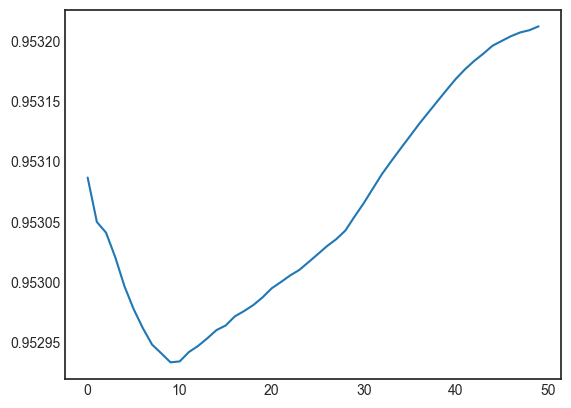

In [322]:

Y_pred_running = np.array([C @ X for C, X in zip(C_running_average, X_running_average)])
nmse_running = [calculate_nmse((Y_temperature * mask_inv), (Y_pred * mask_inv)) for Y_pred in Y_pred_running]
plt.plot(range(T-burnin), nmse_running)


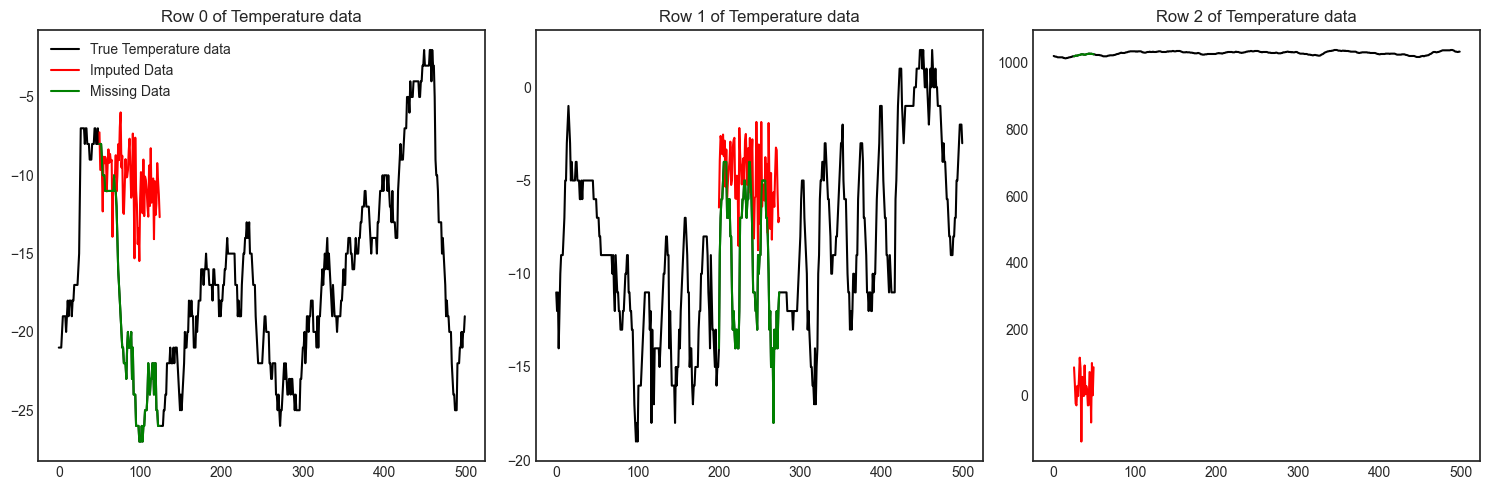

In [323]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

for i in range(3):
    axs[i].plot(Y_temperature[i, :], label='True Temperature data', color = 'black')
    #axs[i].plot(Y_pred[i, :], label='Predicted data', color = 'orange')
    axs[i].set_title(f"Row {i} of Temperature data")

    missing_indices = np.where(mask[i, :] == 0)[0]
    axs[i].plot(missing_indices, Y_pred[i, missing_indices], 'r', label='Imputed Data' if i == 0 else "")
    axs[i].plot(missing_indices, Y_temperature[i, missing_indices], 'green', label='Missing Data' if i == 0 else "")

    if i == 0:
        axs[0].legend()

plt.tight_layout()
plt.show()

### Application to Netflix Data set (with Missing Data)

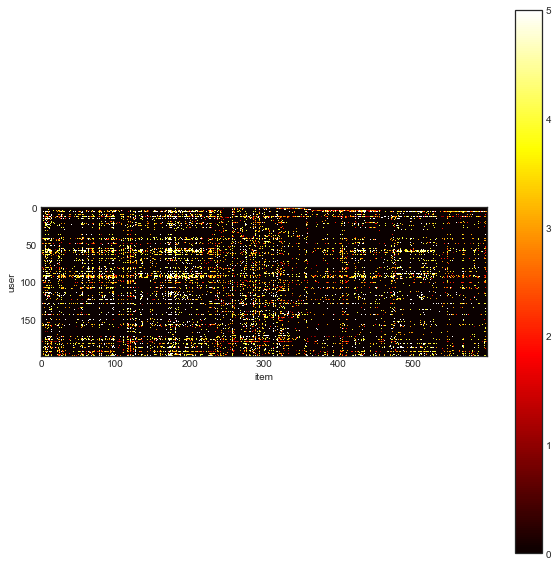

In [30]:
#load movielens data and create a matrix and plot the heatmap
# load the data
df = pd.read_csv('netflix.data', sep='\t', header=None)
df.columns = ['user_id', 'item_id', 'rating', 'timestamp']
# create a matrix
ratings = np.zeros((943, 1682))
for row in df.itertuples():
    ratings[row[1] - 1, row[2] - 1] = row[3]

#use a subset of netflix data to work on
Y = ratings[:200, :600]

# plot the heatmap
plt.figure(figsize=(10, 10))
plt.imshow(Y, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.xlabel('item')
plt.ylabel('user')
plt.savefig('heatmap.png')
plt.show()

In [47]:
np.random.seed(0)

#create mask matrix where matrix is of shape Y, and 0 if entry of Y is 0 and 1 otherwise
mask = (Y != 0).astype(int)

mask_flat = mask.flatten()
indices_of_ones = np.where(mask_flat == 1)[0]
#remove 20% of the data
num_to_remove = int(len(indices_of_ones) * 0.2)
removed_indices_flat = np.random.choice(indices_of_ones, size=num_to_remove, replace=False)

#remove selected indices to 0 in original matrix
mask_flat[removed_indices_flat] = 0
removed_indices = np.zeros_like(mask_flat)

removed_indices[removed_indices_flat] = 1

mask = mask_flat.reshape(mask.shape)
removed_indices = removed_indices.reshape(mask.shape)

Y_removed = mask * Y

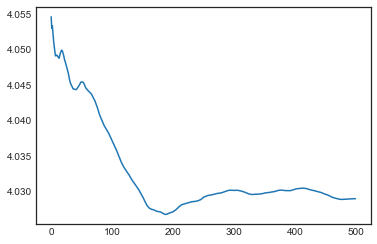

In [41]:
np.random.seed(0)

burnin = 1000
T = 1500
sigma_2 = 1
k = 0.001
r = 100

C_pred, X_pred, C_running_average, X_running_average = BGMF(Y_removed, k, r, T, sigma_2, burnin, return_running_average=True, mask = mask)

Y_pred = C_pred @ X_pred

### NMSE plot only on data that was removed ###

Y_pred_running = np.array([C @ X for C, X in zip(C_running_average, X_running_average)])
nmse_running = [calculate_nmse(Y * removed_indices, Y_pred * removed_indices) for Y_pred in Y_pred_running]

plt.plot(range(T-burnin), nmse_running)

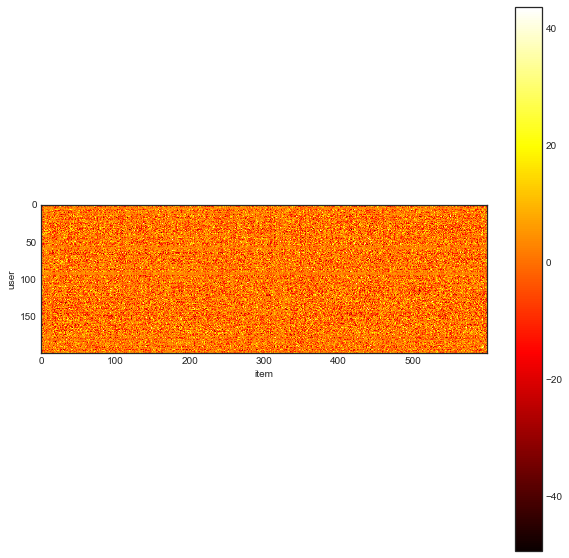

In [43]:
#Plot reconstruction
plt.figure(figsize=(10, 10))
plt.imshow(Y_pred, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.xlabel('item')
plt.ylabel('user')
plt.savefig('heatmap.png')
plt.show()

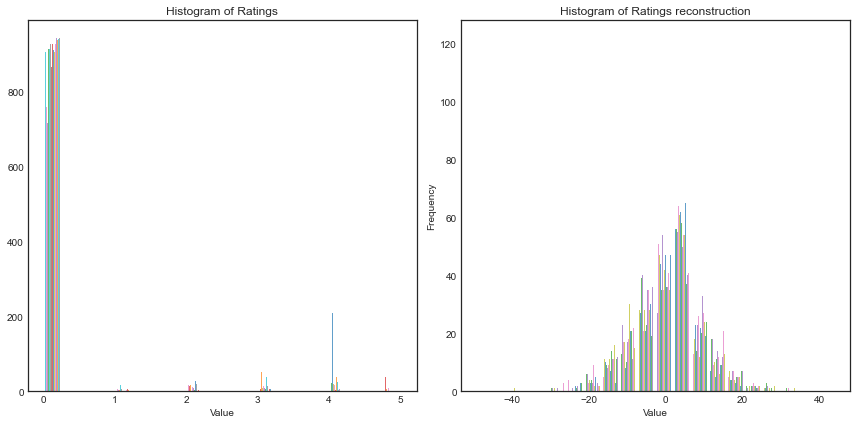

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First subplot for Y_pred
axs[1].hist(Y_pred, bins=20, alpha=0.7)
axs[1].set_title('Histogram of Ratings reconstruction')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')

# Second subplot for ratings
axs[0].hist(ratings, bins=20, alpha=0.7)
axs[0].set_title('Histogram of Ratings')
axs[0].set_xlabel('Value')
# axs[1].set_ylabel('Frequency')  # Optional, as y-axis is same as first plot

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### Oberservation: adjusting k, doesn't help much if T-burnin is larger.

### Marginal Likelihood from BGMF for different values of r

In BGMF, we implement Gibbs Sampling for complete conditionals which we derived:

$$
f(C|Y, X) = \mathcal{N}(c;c_p, V \otimes I_m) = \mathcal{MN}(C;C_p, I_m, V), 
$$
$$
f(X|Y, C) = \mathcal{N}(c;x_p, I_n \otimes W) = \mathcal{MN}(X;X_p, W, I_n), 
$$

Using https://www.tandfonline.com/doi/pdf/10.1080/01621459.1995.10476635, the estimate of the marginal likelihood is:

$$
\log p(Y) = \log P(Y|C^*,X^*) + \log p(X^*) + \log p(C^*) - \log p(C^*|X^*,Y) - \log p(X^*|Y)
$$


where $C^*$ and $X^*$ are our selected points taken to be the average points of sampler output from our outputs of BGMF $\{C^{(t)}, X^{(t)}\}_{t=1}^T$.

The last term can be estimated by:

$$
p(\widehat{X^*|Y}) = \frac{1}{T}\sum_{i=1}^Tp(X^*|C^{(i)}, Y)
$$



In [54]:
def evaluate_log_density(X, M, U, V):
    #evaluates log pdf for X that follows MN(M, U, V)
    n, p = X.shape
    log_density = -0.5 * np.trace(np.linalg.solve(V, (X-M).T) @ np.linalg.solve(U, (X - M)))
    log_density -= 0.5 * (n * p * np.log(2*np.pi) + n * np.log(np.linalg.det(V)) + p * np.log(np.linalg.det(U)))
    return log_density

In [55]:
def log_marginal_likelihood(C_samples, X_samples, V_samples, W_samples, Y, sigma_2, C_0, X_0, V_0, W_0):
    
    m, n = Y.shape
    C_star = calculate_running_average(C_samples)[-1]
    X_star = calculate_running_average(X_samples)[-1]
    T = len(X_samples)
    term1 = evaluate_log_density(Y, C_star@X_star, sigma_2*np.eye(m), sigma_2*np.eye(n))
    term2 = evaluate_log_density(X_star, X_0, W_0, np.eye(n))
    term3 = evaluate_log_density(C_star, C_0, np.eye(m), V_0)
    
    C_p = C_0 + (Y - C_0 @ X_star) @ np.linalg.inv((sigma_2*np.eye(n) + X_star.T @ V_0 @ X_star)).T @ X_star.T @ V_0.T
    V_p = V_0 - V_0 @ X_star @ np.linalg.inv(sigma_2*np.eye(n) + X_star.T @ V_0 @ X_star).T @ X_star.T @ V_0.T
    term4 = evaluate_log_density(C_star, C_p, np.eye(m), V_p)
    
    X_p_array = [X_0 + W_0 @ C_i.T @ np.linalg.inv(sigma_2*np.eye(m) + C_i @ W_0 @ C_i.T) @ (Y - C_i @ X_0) for C_i in C_samples]
    #W_p = W_0 - W_0 @ C_star.T @ np.linalg.inv(sigma_2*np.eye(m) + C_star @ W_0 @ C_star.T) @ C_star @ W_0
    W_p_array = [W_0 - W_0 @ C_i.T @ np.linalg.inv(sigma_2*np.eye(m) + C_i @ W_0 @ C_i.T) @ C_i @ W_0 for C_i in C_samples]
    
    #term5_log_array = [evaluate_log_density(X_star, X_p, W_p, np.eye(n)) for X_p in X_p_array]
    term5_log_array = [evaluate_log_density(X_star, X_p, W_p, np.eye(n)) for X_p, W_p in zip(X_p_array, W_p_array)]
    
    term5 = logsumexp(term5_log_array) - np.log(T)
    print(term1, term2, term3, term4, term5)
    return term1 + term2 + term3 - term4 - term5
    

In [56]:
res = log_marginal_likelihood(C_samples, X_samples, V_samples, W_samples, Y, sigma_2, C_0, X_0, V_0, W_0)


-6828.062549244843 -28443628.062712528 -3034706.9474757067 -393031.35664351005 -4794243.184760649


### Plot for different values of r

-227.5243394119867 -2275.3039671355887 -1179.007308627244 -876.7352017228583 -2096.0693696523526
-137.65740606434173 -3110.712882433425 -1299.8610649339912 -1086.377150004282 -2885.1567069975026
-111.88938718145539 -3584.9892824522417 -2894.4728878614933 -2442.413311428184 -3357.062031599191
-98.58499307463752 -3250.558143240826 -2171.2264088157885 -1849.7351570028318 -3063.493969781885
-103.45427183208521 -6958.840609501921 -3141.8012786163927 -2723.008760546315 -6647.3436947336195
-100.3811540091524 -5897.780901150836 -3087.32669533795 -2664.474424104043 -5668.4598943837145
-101.29509351664808 -9995.167802064965 -1982.4836387299101 -1490.5632829067818 -9796.479160726989
-99.73840381745599 -6741.914163826691 -3002.910760032274 -2721.935839678127 -6376.821156810735
-102.69435925831056 -9014.756422785274 -3783.7603517941343 -3218.6393415427337 -8546.616454202232


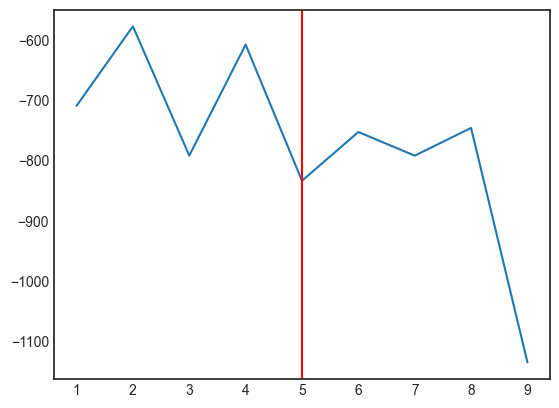

In [58]:
np.random.seed(0)
m = 7
n = 13
true_r = 5
burnin = 1000
T = 5000
k = 0.01
sigma_2 = 1

r_vals = [i for i in range(1, 10)]
log_likelihoods = []

#Generate data
C = np.random.normal(0, 1, size=(m, true_r))
X = np.random.normal(0, 1, size=(true_r, n))
Y = C @ X

for r in r_vals:
    C_pred, X_pred, C_samples, X_samples, V_samples, W_samples, C_0, X_0, V_0, W_0, _, _ \
                    = BGMF(Y, k, r, T, sigma_2, burnin = burnin, return_samples = True)
    
    log_likelihoods.append(log_marginal_likelihood(C_samples, X_samples, V_samples, W_samples, Y, sigma_2, C_0, X_0, V_0, W_0))
    
plt.plot(r_vals, log_likelihoods)
plt.axvline(true_r, color='r')